BERT + CNN for Hate Speech Recognition (English)

Fuente del código https://github.com/ZeroxTM/BERT-CNN-Fine-Tuning-For-Hate-Speech-Detection-in-Online-Social-Media

# Librerías

In [ ]:
!pip install transformers==3.0.0
!pip install emoji
import gc
#import os
import emoji as emoji
import re
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoModel
from transformers import BertModel, BertTokenizer

     |████████████████████████████████| 757kB 9.5MB/s 
     |████████████████████████████████| 3.0MB 15.8MB/s 
     |████████████████████████████████| 901kB 33.7MB/s 
     |████████████████████████████████| 1.2MB 53.6MB/s 
     |████████████████████████████████| 133kB 7.5MB/s 


# BERT Architecture

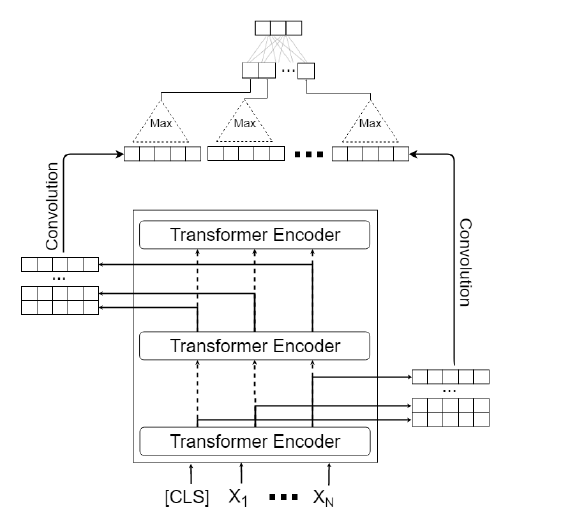

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.conv = nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 768), padding=True) #convolutional 
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(442, 3) # before : 442 with max_length 36 # 806 with max_length 64
        self.flat = nn.Flatten()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        _, _, all_layers = self.bert(sent_id, attention_mask=mask, output_hidden_states=True) #Estados ocultos
        # all_layers 
        x = torch.transpose(torch.cat(tuple([t.unsqueeze(0) for t in all_layers]), 0), 0, 1)
        del all_layers
        gc.collect() #Garbage Collector
        torch.cuda.empty_cache()
        x = self.pool(self.dropout(self.relu(self.conv(self.dropout(x)))))
        x = self.fc(self.dropout(self.flat(self.dropout(x))))
        return self.softmax(x)

# Tweets

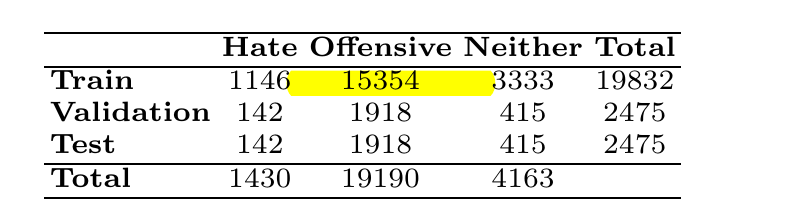

In [ ]:
def read_dataset():
    data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/proyectoNLP/data/labeled_data.csv")
    data = data.drop(['count', 'hate_speech', 'offensive_language', 'neither'], axis=1)
    #data = data.loc[0:9599,:]
    print(len(data))
    return data['tweet'].tolist(), data['class']


def pre_process_dataset(values):
    new_values = list()
    # Emoticons
    emoticons = [':-)', ':)', '(:', '(-:', ':))', '((:', ':-D', ':D', 'X-D', 'XD', 'xD', 'xD', '<3', '</3', ':\*',
                 ';-)',
                 ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':((', ':D', '=D',
                 '=)',
                 '(=', '=(', ')=', '=-O', 'O-=', ':o', 'o:', 'O:', 'O:', ':-o', 'o-:', ':P', ':p', ':S', ':s', ':@',
                 ':>',
                 ':<', '^_^', '^.^', '>.>', 'T_T', 'T-T', '-.-', '*.*', '~.~', ':*', ':-*', 'xP', 'XP', 'XP', 'Xp',
                 ':-|',
                 ':->', ':-<', '$_$', '8-)', ':-P', ':-p', '=P', '=p', ':*)', '*-*', 'B-)', 'O.o', 'X-(', ')-X']

    for value in values:
        # Remove dots
        text = value.replace(".", "").lower()
        text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
        users = re.findall("[@]\w+", text)
        for user in users:
            text = text.replace(user, "<user>")
        urls = re.findall(r'(https?://[^\s]+)', text)
        if len(urls) != 0:
            for url in urls:
                text = text.replace(url, "<url >")
        for emo in text:
            if emo in emoji.UNICODE_EMOJI:
                text = text.replace(emo, "<emoticon >")
        for emo in emoticons:
            text = text.replace(emo, "<emoticon >")
        numbers = re.findall('[0-9]+', text)
        for number in numbers:
            text = text.replace(number, "<number >")
        text = text.replace('#', "<hashtag >")
        text = re.sub(r"([?.!,¿])", r" ", text)
        text = "".join(l for l in text if l not in string.punctuation)
        text = re.sub(r'[" "]+', " ", text)
        new_values.append(text)
    return new_values


def data_process(data, labels):
    input_ids = []
    attention_masks = []
    dict_tweets=[]
    d_t={}
    i=0
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    for sentence in data:
        bert_inp = bert_tokenizer.__call__(sentence, max_length=36,
                                           padding='max_length', pad_to_max_length=True,
                                           truncation=True, return_token_type_ids=False)
        d_t[i]=sentence
        i=i+1
        dict_tweets.append((bert_inp['input_ids'],sentence))
        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])
    #del bert_tokenizer
    #gc.collect()
    #torch.cuda.empty_cache()
    input_ids = np.asarray(input_ids)
    attention_masks = np.array(attention_masks)
    labels = np.array(labels)
    return input_ids, attention_masks, labels


def load_and_process():
    data, labels = read_dataset()
    num_of_labels = len(labels.unique())
    input_ids, attention_masks, labels  = data_process(pre_process_dataset(data), labels)

    return input_ids, attention_masks, labels, data

# Funciones de Entrenamiento y Evaluación del Modelo

In [ ]:
# function to train the model
def train():
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches
    total = len(train_dataloader)
    for i, batch in enumerate(train_dataloader):

        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>'  *(filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}', end='')

        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        #sent_id = torch.tensor(sent_id).to(device).long()
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss += float(loss.item())

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        #preds = preds.detach().cpu().numpy()


        # append the model predictions
        #total_preds.append(preds)
        total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()

    # compute the training loss of the epoch
    avg_loss = total_loss / (len(train_dataloader)*batch_size)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss and predictions
    return avg_loss, total_preds
# function for evaluating the model
def evaluate():
    print("\n\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    total = len(val_dataloader)
    for i, batch in enumerate(val_dataloader):
        
        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>' * (filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss += float(loss.item())
            #preds = preds.detach().cpu().numpy()

            #total_preds.append(preds)
            total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()

    # compute the validation loss of the epoch
    avg_loss = total_loss / (len(val_dataloader)*batch_size)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

# Entrenamiento y Evaluación + Clasificación

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://morioh.com/p/eabbdfdd1f0b

In [ ]:
# Specify the GPU
# Setting up the device for GPU usage
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Load Data-set ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
input_ids, attention_masks, labels, data = load_and_process()
df = pd.DataFrame(list(zip(input_ids, attention_masks,data)), columns=['input_ids', 'attention_masks','tweets'])
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ class distribution ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
# ~~~~~~~~~~ Split train data-set into train, validation and test sets  ~~~~~~~~~~#
train_text, temp_text, train_labels, temp_labels = train_test_split(df[['input_ids', 'attention_masks']], labels,
                             random_state=2018, test_size=0.2, stratify=labels)

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                         random_state=2018, test_size=0.5, stratify=temp_labels)

cuda
24783


In [ ]:
df

,input_ids,attention_masks,tweets
0,"[101, 19387, 9815, 19454, 21818, 2135, 2004, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",!!! RT @mayasolovely: As a woman you shouldn't...
1,"[101, 19387, 19875, 4402, 2860, 2879, 23755, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,"[101, 19387, 24471, 18824, 11253, 23544, 4830,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,"[101, 19387, 1039, 1043, 5143, 20022, 2241, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,"[101, 19387, 21882, 7556, 3217, 8296, 2015, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...
24778,"[101, 2017, 1055, 1037, 14163, 8322, 2546, 199...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,"[101, 2017, 2310, 2908, 1998, 3631, 1996, 3308...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","you've gone and broke the wrong heart baby, an..."
24780,"[101, 2402, 10131, 10587, 4521, 23755, 9152, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",young buck wanna eat!!.. dat nigguh like I ain...
24781,"[101, 2017, 2226, 2288, 3748, 7743, 2229, 2425...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",youu got wild bitches tellin you lies


In [ ]:
del temp_text
gc.collect()
torch.cuda.empty_cache()

train_count = len(train_labels)
test_count = len(test_labels)
val_count = len(val_labels)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~ Import BERT Model and BERT Tokenizer ~~~~~~~~~~~~~~~~~~~~~#
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
# bert = AutoModel.from_pretrained('bert-base-uncased')
# Load the BERT tokenizer
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Tokenization ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for train set
train_seq = torch.tensor(train_text['input_ids'].tolist())
train_mask = torch.tensor(train_text['attention_masks'].tolist())
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(val_text['input_ids'].tolist())
val_mask = torch.tensor(val_text['attention_masks'].tolist())
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(test_text['input_ids'].tolist())
test_mask = torch.tensor(test_text['attention_masks'].tolist())
test_y = torch.tensor(test_labels.tolist())
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Create DataLoaders ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Freeze BERT Parameters ~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
# push the model to GPU
model = model.to(device)

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)


# loss function
cross_entropy = nn.NLLLoss()

# set initial loss to infinite
best_valid_loss = float('inf')

In [ ]:
# number of training epochs
epochs = 3
current = 1
# for each epoch
while current <= epochs:

    print(f'\nEpoch {current} / {epochs}:')

    # train model
    train_loss, _ = train()

    # evaluate model
    valid_loss, _ = evaluate()

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'saved_weights.pth')

    # append training and validation loss
    #train_losses.append(train_loss)
    #valid_losses.append(valid_loss)

    print(f'\n\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    current = current + 1


Epoch 1 / 3:
Batch 620/620 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01

Evaluating...
Batch 78/78 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Training Loss: 0.011
Validation Loss: 0.007

Epoch 2 / 3:
Batch 620/620 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01

Evaluating...
Batch 78/78 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Training Loss: 0.007
Validation Loss: 0.008

Epoch 3 / 3:
Batch 620/620 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01

Evaluating...
Batch 78/78 |█████████████████████████████████████████████████████████████████

In [ ]:
# get predictions for test data
gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    #preds = model(test_seq, test_mask)
    preds = preds.detach().cpu().numpy()


print("Performance:")
# model's performance
preds = np.argmax(preds, axis=1)
print('Classification Report')
print(classification_report(test_y, preds))

print("Accuracy: " + str(accuracy_score(test_y, preds)))

Performance:
Classification Report
              precision    recall  f1-score   support

           0       0.58      0.29      0.38       143
           1       0.94      0.97      0.95      1919
           2       0.88      0.91      0.90       417

    accuracy                           0.92      2479
   macro avg       0.80      0.72      0.74      2479
weighted avg       0.91      0.92      0.91      2479

Accuracy: 0.918918918918919


#Error Analysis

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Confusion Matrix

In [ ]:
confusion_matrix(test_y,preds)

array([[  41,   88,   14],
       [  26, 1856,   37],
       [   4,   32,  381]])

Get the test tweets

In [ ]:
test_text

,input_ids,attention_masks
10873,"[101, 1045, 2156, 8038, 2502, 8945, 2072, 1999...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
20981,"[101, 2061, 5305, 1997, 2017, 8275, 4632, 7570...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
15116,"[101, 19387, 2563, 26068, 3051, 3407, 5798, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7671,"[101, 2471, 3071, 1045, 2777, 1999, 3000, 2001...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
19947,"[101, 19387, 4575, 9006, 8571, 2854, 1045, 222...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...
23093,"[101, 8038, 3363, 3404, 2378, 2122, 7570, 2229...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
14578,"[101, 19387, 2655, 13759, 24045, 10710, 3683, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
18960,"[101, 19387, 3449, 15459, 6873, 19563, 2480, 8...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5729,"[101, 8812, 2098, 12762, 6583, 27421, 10484, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
labels={0:'Hate Speech', 1: 'Offensive Language', 2: 'Neither'}

In [ ]:
df['tweets'][0]

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

***The missclassified ones***

In [ ]:
y=np.array(test_y)
y_h=preds  
for i,t in enumerate(test_text.index):
  if y[i] != y_h[i]:
    if y_h[i]==2:
      print('tweet: %s'%df['tweets'][t],'\n')
      print('True: %s' %labels[y[i]],'\n')
      print('Pred: %s' %labels[y_h[i]],'\n')

tweet: In redneck land ;) #Tennessee 

True: Offensive Language 

Pred: Neither 

tweet: "That girl is plain looking borderline ugly &amp; chunky". Hey at least she's got a nice smile &amp; a great personality. 

True: Offensive Language 

Pred: Neither 

tweet: Damn girl I'll be your porch monkey 

True: Offensive Language 

Pred: Neither 

tweet: RT @Kevin_McAdams: @WhaleLookyHere tbh I didn't even mean to mock him but #itstoofuckingeasy 

True: Offensive Language 

Pred: Neither 

tweet: I missing something of my ofay friends. Day all scared by da recent happenings. Don't chu worry...ol Lamar say you like da colored folk 

True: Hate Speech 

Pred: Neither 

tweet: RT @FunSizedYogi: @TheBlackVoice well how else will white ppl get us to forget our horrific past other than to paint a pretty picture of ho&#8230; 

True: Hate Speech 

Pred: Neither 

tweet: Stop trying to be down honky http://t.co/0MALBNDkn9 

True: Offensive Language 

Pred: Neither 

tweet: WTF is this chick singing t

Human corders consider homophobic slurs to be hateful.

In [ ]:
text_test=[]
for i,t in enumerate(test_text.index):
  text_test.append(df['tweets'][t])

In [ ]:
def get_misccl(word):
  y=np.array(test_y)
  for i,t in enumerate(text_test):
    aux=t.split(' ')
    if word in aux:
      if y[i] != preds[i]:
        print('tweet: %s' %t,'\n pred: %s'%labels[preds[i]], '\n true: %s' %labels[y[i]],'\n')

In [ ]:
get_misccl('faggot')

tweet: RT @EnglandBailey: Happy birthday to the nicest faggot ever &#128129; http://t.co/vZygNI9qtQ 
 pred: Hate Speech 
 true: Offensive Language 

tweet: @joshgnf @brana_nv @define808 @ironbjk @mrjstn oh shut up faggot get a disease overused on twitter 
 pred: Offensive Language 
 true: Hate Speech 

tweet: @AustinG1135 I do not like talking to you faggot and I did but in a nicely way fag 
 pred: Offensive Language 
 true: Hate Speech 

tweet: @justinbieber have fun getting deported you fucking faggot 
 pred: Hate Speech 
 true: Offensive Language 

tweet: Accept your flaws and imperfections because that's what makes you, YOU! See I'm a fuck, small dick faggot with parents who don't love me. 
 pred: Offensive Language 
 true: Hate Speech 

tweet: Starks being a faggot 
 pred: Hate Speech 
 true: Offensive Language 

tweet: @AustinG1135 answer my snapchat faggot 
#butthurt 
 pred: Offensive Language 
 true: Hate Speech 

tweet: @_TriggaPlease_ @kanyewest he's a faggot 
 pred: Offensiv

In [ ]:
get_misccl('pussy')

tweet: @kieffer_jason oh but I am and my grades say other wise so u can stfu and get off my Twitter or u can box simple ass that pussy boy 
 pred: Offensive Language 
 true: Hate Speech 

tweet: RT @divonte_photos: Momma said no pussy cats inside of my dog house. 
 pred: Neither 
 true: Offensive Language 

tweet: harm this pussy instead RT @ABC7: missing 26-yr-old USC medical student last seen Tuesday May harm himself http://t.co/evU04p6SUR 
 pred: Offensive Language 
 true: Hate Speech 

tweet: At pussy cat lounge killin it with my girlz @blaqdior and @hpmiss 
 pred: Offensive Language 
 true: Neither 

tweet: Pantera - 5 Minutes Alone http://t.co/SrN5Yc16 @chrisrock 5 minutes, pussy boy..I'll crush you. 
 pred: Offensive Language 
 true: Hate Speech 



In [ ]:
get_misccl('nigga')

tweet: RT @ajade___: everybody tryna fuck the next nigga bitch not knowin that his bitch is the next nigga bitch &#128586;&#128566; 
 pred: Offensive Language 
 true: Hate Speech 

tweet: nigga u a cunt where yo fendi clutch 
 pred: Offensive Language 
 true: Hate Speech 

tweet: @tori_mills02 I believe that you fuckin can punk nigga bitch&#128520;&#128170; 
 pred: Offensive Language 
 true: Hate Speech 

tweet: RT @PacDaGoat: You a hoe if you give your number to another nigga while you got a man 
 pred: Offensive Language 
 true: Hate Speech 

tweet: RT @NerdAtCoolTable: RT @RealSheemBacc: For every bad bitch there is a nigga who treats them like shit &amp; yet they stay..... I wanna ... 
 pred: Offensive Language 
 true: Hate Speech 

tweet: RT @InkMyHoleBody: This nigga is a fuckin faggot https://t.co/e3m6tujnhF 
 pred: Offensive Language 
 true: Hate Speech 

tweet: Delete now you bitch ass nigga RT @Quanny_Quan: If the Redskins beat us I will delete my fucking IG 
 pred: Offensive

In [ ]:
get_misccl('bitch')

tweet: RT @lildurk_: I don't fuck with bitch niggas I only fuck niggas bitches&#128556; 
 pred: Offensive Language 
 true: Hate Speech 

tweet: RT @FeelinYurTHROAT: Don't watch me you beta watch your bitch nigga! 
 pred: Offensive Language 
 true: Hate Speech 

tweet: RT @ajade___: everybody tryna fuck the next nigga bitch not knowin that his bitch is the next nigga bitch &#128586;&#128566; 
 pred: Offensive Language 
 true: Hate Speech 

tweet: Dumb bitch https://t.co/We46wO15nI 
 pred: Offensive Language 
 true: Hate Speech 

tweet: RT @JHazeThaGod: You other niggas a call up a bitch to fight a bitch naw not me I'm whomp that trick so she can feel where I'm coming from 
 pred: Offensive Language 
 true: Hate Speech 

tweet: You know what fuck you too bitch your such a little hoe! &gt;.&lt; 
 pred: Offensive Language 
 true: Hate Speech 

tweet: Bitch ass nigga, be hating on black women... Uncle Tom bitch punk. 
 pred: Offensive Language 
 true: Hate Speech 

tweet: RT @NerdAtCoolTabl

# Word Cloud

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/proyectoNLP/data/labeled_data.csv")
data = data.drop(['Unnamed: 0','count', 'hate_speech', 'offensive_language', 'neither'], axis=1)

In [ ]:
data_tweets=pre_process_dataset(data['tweet'].tolist())

In [ ]:
data_tweets

[' rt mayasolovely as a woman you shouldn t complain about cleaning up your house amp as a man you should always take the trash out',
 ' rt mleew boy dats coldtyga dwn bad for cuffin dat hoe in the st place ',
 ' rt urkindofbrand dawg rt sbaby life you ever fuck a bitch and she start to cry you be confused as shit',
 ' rt c g anderson viva based she look like a tranny',
 ' rt shenikaroberts the shit you hear about me might be true or it might be faker than the bitch who told it to ya ',
 ' t madison x the shit just blows meclaim you so faithful and down for somebody but still fucking with hoes ',
 ' brighterdays i can not just sit up and hate on another bitch i got too much shit going on ',
 ' selfiequeenbri cause i m tired of you big bitches coming for us skinny girls ',
 ' amp you might not get ya bitch back amp thats that ',
 ' rhythmixx hobbies include fighting mariam bitch',
 ' keeks is a bitch she curves everyone lol i walked into a conversation like this smh',
 ' murda gang bitc

In [ ]:
import nltk
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
text = " ".join(tw for tw in data_tweets)
text

' rt mayasolovely as a woman you shouldn t complain about cleaning up your house amp as a man you should always take the trash out  rt mleew boy dats coldtyga dwn bad for cuffin dat hoe in the st place   rt urkindofbrand dawg rt sbaby life you ever fuck a bitch and she start to cry you be confused as shit  rt c g anderson viva based she look like a tranny  rt shenikaroberts the shit you hear about me might be true or it might be faker than the bitch who told it to ya   t madison x the shit just blows meclaim you so faithful and down for somebody but still fucking with hoes   brighterdays i can not just sit up and hate on another bitch i got too much shit going on   selfiequeenbri cause i m tired of you big bitches coming for us skinny girls   amp you might not get ya bitch back amp thats that   rhythmixx hobbies include fighting mariam bitch  keeks is a bitch she curves everyone lol i walked into a conversation like this smh  murda gang bitch its gang land   so hoes that smoke are lose

In [ ]:
def get_cloud(text,title):
  stopwords = set(STOPWORDS)
  #stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

  # Generate a word cloud image
  #wordcloud = WordCloud(width=1500,height=1000,max_words=500,stopwords=stopwords, background_color="white").generate(text)

  font = '/content/drive/MyDrive/Colab Notebooks/Quicksand-Bold.ttf'
  custom_mask = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/heart.png"))
  word_cloud = WordCloud(font_path=font, mask=custom_mask,
                       width=4000,
                       height=4000,
                       colormap='PuRd',
                       margin=0,
                       max_words=100, 
                       stopwords=stopwords,
                       background_color="white").generate(text)

  image_colors = ImageColorGenerator(custom_mask)
  word_cloud.recolor(color_func=image_colors)
  plt.figure(figsize=(12, 12))
  plt.imshow(word_cloud, interpolation='gaussian')
  plt.axis("off")
  plt.title(title)
  plt.show()

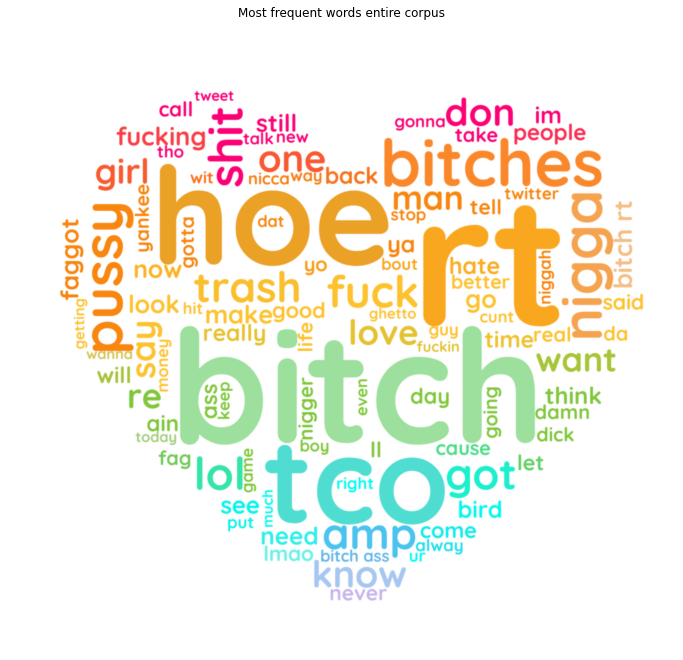

In [ ]:
get_cloud(text,'Most frequent words entire corpus')

In [ ]:
clase=np.array(data['class'])

In [ ]:
HS_tweets=" ".join(tw for i,tw in enumerate(data_tweets) if clase[i]==0)

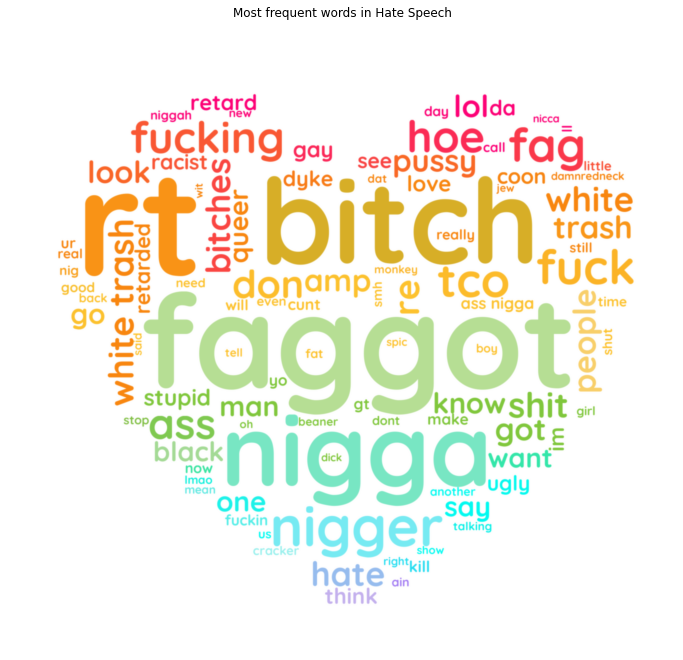

In [ ]:
get_cloud(HS_tweets,'Most frequent words in Hate Speech')

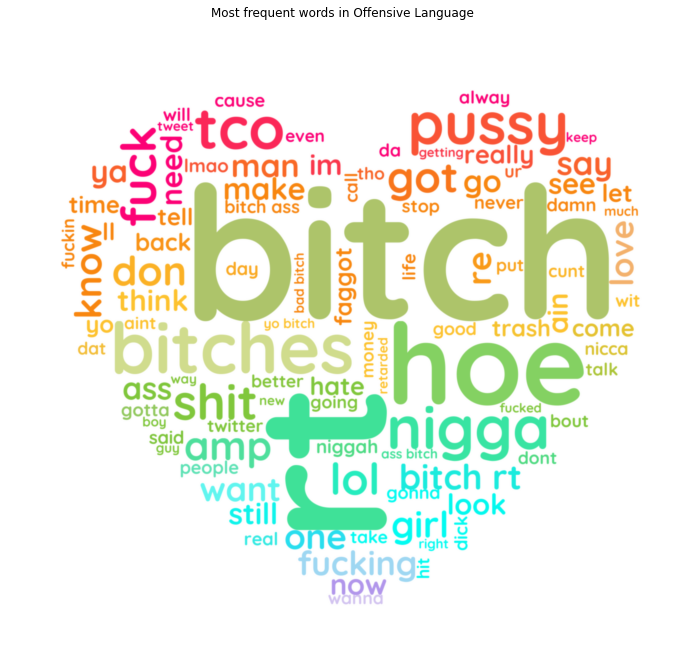

In [ ]:
OL_tweets=" ".join(tw for i,tw in enumerate(data_tweets) if clase[i]==1)
get_cloud(OL_tweets,'Most frequent words in Offensive Language')

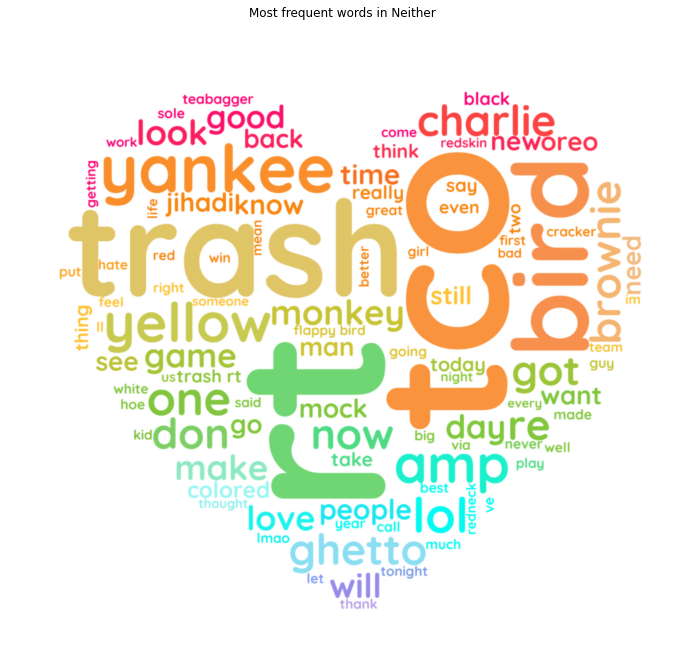

In [ ]:
OL_tweets=" ".join(tw for i,tw in enumerate(data_tweets) if clase[i]==2)
get_cloud(OL_tweets,'Most frequent words in Neither')